In [11]:

import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import feature
import utils
import blend

In [12]:
pool = mp.Pool(mp.cpu_count())

img_list, focal_length = utils.parse('../input_image/denny')

print('Warp images to cylinder')
cylinder_img_list = pool.starmap(utils.cylindrical_projection, [(img_list[i], float(focal_length[i])) for i in range(len(img_list))])

shifts = []
direction = ''
_, img_width, _ = img_list[0].shape
blended_image = cylinder_img_list[0].copy()

Warp images to cylinder


In [13]:
img1 = blended_image
img2 = cylinder_img_list[1]

if direction != '':
    img1 = blended_image[:, :img_width] if direction == 'left' else blended_image[:, -img_width:]

print(' - Find features in previous img .... ', end='', flush=True)
corner_response1 = feature.harris_corner(img1)
descriptors1, position1 = feature.extract_description(img1, corner_response1, kernel=5, threshold=0.05)
print(str(len(descriptors1))+' features extracted.')

print(' - Find features in img_ .... ', end='', flush=True)
corner_response2 = feature.harris_corner(img2)
descriptors2, position2 = feature.extract_description(img2, corner_response2, kernel=5, threshold=0.05)
print(str(len(descriptors2))+' features extracted.')

if False:
    cv2.imshow('cr1', corner_response1)
    cv2.imshow('cr2', corner_response2)
    cv2.waitKey(0)

print(' - Feature matching .... ', end='', flush=True)
mpp = feature.matching(descriptors1, descriptors2, position1, position2)
print(str(len(mpp)) +' features matched.')

print(' - Find best shift using RANSAC .... ', end='', flush=True)
shift = blend.RANSAC(mpp)
shifts += [shift]
print('best shift ', shift)
if direction == '':
    direction = 'left' if shift[1] > 0 else 'right'

 - Find features in previous img .... 1876 features extracted.
 - Find features in img_ .... 3222 features extracted.
 - Feature matching .... 107 features matched.
 - Find best shift using RANSAC .... best shift  [  -2 -253]


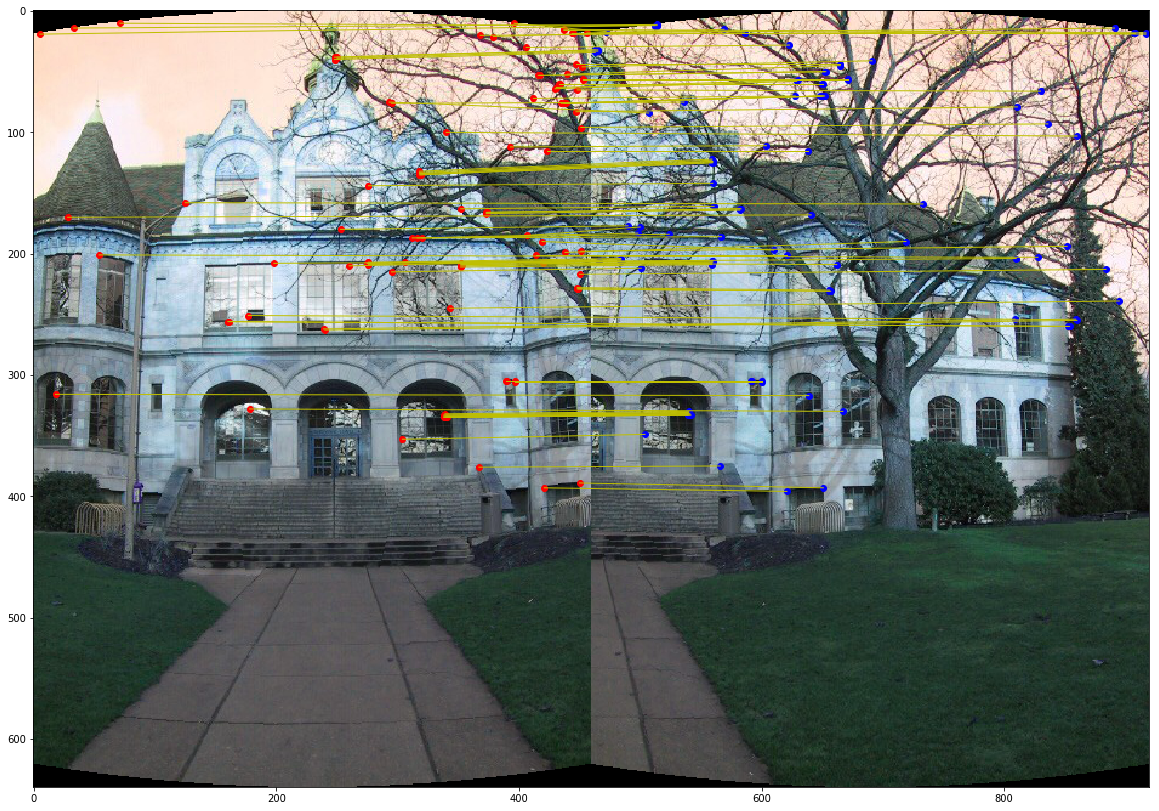

In [23]:
_, offset, _ = img1.shape
plt_img = np.concatenate((img1, img2), axis=1)
plt.figure(figsize=(20,20))
plt.imshow(plt_img)
for i in range(len(mpp)//1):
    plt.scatter(x=mpp[i][0][1], y=mpp[i][0][0], c='r')
    plt.plot([mpp[i][0][1], offset+mpp[i][1][1]], [mpp[i][0][0], mpp[i][1][0]], 'y-', lw=1)
    plt.scatter(x=offset+mpp[i][1][1], y=mpp[i][1][0], c='b')
plt.show()

In [19]:
def blending(img1, img2, shift, pool):
    padding = [
        (shift[0], 0) if shift[0] > 0 else (0, -shift[0]),
        (shift[1], 0) if shift[1] > 0 else (0, -shift[1]),
        (0, 0)
    ]
    shifted_img1 = np.lib.pad(img1, padding, 'constant', constant_values=0)
    split = img2.shape[1]+abs(shift[1])
    splited = shifted_img1[:, split:] if shift[1] > 0 else shifted_img1[:, :-split]
    shifted_img1 = shifted_img1[:, :split] if shift[1] > 0 else shifted_img1[:, -split:]
    
    h1, w1, _ = shifted_img1.shape
    h2, w2, _ = img2.shape
    
    inv_shift = [h1-h2, w1-w2]
    inv_padding = [
        (inv_shift[0], 0) if shift[0] < 0 else (0, inv_shift[0]),
        (inv_shift[1], 0) if shift[1] < 0 else (0, inv_shift[1]),
        (0, 0)
    ]
    shifted_img2 = np.lib.pad(img2, inv_padding, 'constant', constant_values=0)
    
    plt.imshow(shifted_img1)
    plt.show()

    direction = 'left' if shift[1] > 0 else 'right'
    #shifted_img1 = pool.starmap(get_new_row_colors, [(shifted_img1[y], shifted_img2[y], direction) for y in range(h1)])
    for y in range(h1):
        shifted_img1[y] = get_new_row_colors(shifted_img1[y], shifted_img2[y], direction)
      
    shifted_img1 = np.asarray(shifted_img1)
    shifted_img1 = np.concatenate((shifted_img1, splited), axis=1)
    return shifted_img1

def get_new_row_colors(row1, row2, direction):
    new_row = np.zeros(shape=row1.shape, dtype=np.uint8)

    for x in range(len(row1)):
        color1 = row1[x]
        color2 = row2[x]
        if list(color1) == [0, 0, 0]:
            new_row[x] = color2
        elif list(color2) == [0, 0, 0]:
            new_row[x] = color1
        else:
            ratio = x/len(row1) if direction == 'left' else (1-x/len(row1))
            # if ((color1 - color2)**2).sum() > 1000:
            #     ratio = 1
            new_row[x] = (1-ratio)*color2 + ratio*color1

    return new_row

 - Blending image .... 

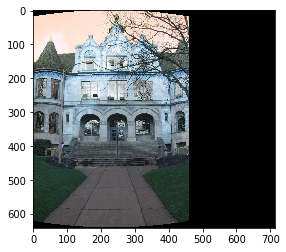

Saved.


In [20]:
print(' - Blending image .... ', end='', flush=True)
ggg = blending(blended_image, img2, shift, pool)
print('Saved.')

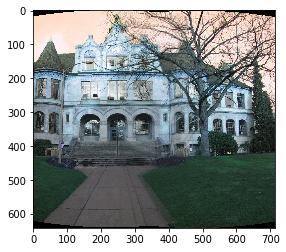

In [21]:

plt.imshow(ggg)
plt.show()